# Bibliotecas

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import datetime
from pandas_profiling import ProfileReport
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Leitura do arquivo completo de casos de covid-19 em Vitória - ES

In [2]:
data = pd.read_excel('coviddata.xlsx')
data.head()

In [ ]:
data.shape

(574745, 45)

## Filtrando apenas para os casos confirmados da doença

In [ ]:
data.Classificacao.unique()

array(['Suspeito', 'Descartados', 'Síndrome Gripal não Especificada',
       'Confirmados'], dtype=object)

In [ ]:
data_confirmados = data.query('Classificacao == "Confirmados"')
data_confirmados.shape

(148561, 45)

In [ ]:
data_confirmados = data_confirmados.drop(columns=['Classificacao'])
data_confirmados.to_csv('coviddata.csv', index= False)

# Lendo arquivo csv apenas com os casos confirmados

In [107]:
df = pd.read_csv('coviddata.csv')
df.head()

C:\Users\R2\AppData\Local\Temp\ipykernel_19752\1454765682.py:1: DtypeWarning: Columns (3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('coviddata.csv')


DataNotificacao                           DataCadastro  \
0  quarta-feira, 19 de maio de 2021      segunda-feira, 24 de maio de 2021   
1   domingo, 19 de dezembro de 2021  segunda-feira, 20 de dezembro de 2021   
2   domingo, 19 de dezembro de 2021  segunda-feira, 20 de dezembro de 2021   
3   domingo, 19 de dezembro de 2021  segunda-feira, 20 de dezembro de 2021   
4   domingo, 19 de dezembro de 2021  segunda-feira, 20 de dezembro de 2021   

                         DataDiagnostico DataColeta_RT_PCR  \
0       quarta-feira, 19 de maio de 2021               NaN   
1  segunda-feira, 13 de dezembro de 2021               NaN   
2        domingo, 19 de dezembro de 2021               NaN   
3        domingo, 12 de dezembro de 2021               NaN   
4   quarta-feira, 15 de dezembro de 2021               NaN   

  DataColetaTesteRapido DataColetaSorologia DataColetaSorologiaIGG  \
0                   NaN                 NaN                    NaN   
1                   NaN                 NaN                    NaN   
2                   NaN                 NaN                    NaN   
3                   NaN                 NaN                    NaN   
4                   NaN                 NaN                    NaN   

  DataEncerramento DataObito Evolucao  ...   ViagemBrasil ViagemInternacional  \
0              NaN       NaN        -  ...  Não Informado       Não Informado   
1              NaN       NaN     Cura  ...            Não                 Não   
2              NaN       NaN     Cura  ...            Não                 Não   
3              NaN       NaN     Cura  ...            Não                 Não   
4              NaN       NaN     Cura  ...            Não                 Não   

  ProfissionalSaude PossuiDeficiencia MoradorDeRua ResultadoRT_PCR  \
0          Ignorado               Não          Não   Não Informado   
1               Não               Não          Não   Não Informado   
2               Não               Não          Não   Não Informado   
3               Não               Não          Não   Não Informado   
4               Não               Não          Não   Não Informado   

  ResultadoTesteRapido ResultadoSorologia ResultadoSorologia_IGG  \
0        Não Informado      Não Informado          Não Informado   
1        Não Informado      Não Informado          Não Informado   
2        Não Informado      Não Informado          Não Informado   
3        Não Informado      Não Informado          Não Informado   
4        Não Informado      Não Informado          Não Informado   

  TipoTesteRapido  
0   Não Informado  
1   Não Informado  
2   Não Informado  
3   Não Informado  
4   Não Informado  

[5 rows x 44 columns]

In [108]:
df.shape

(148561, 44)

# Variável resposta

In [109]:
df.Evolucao.unique()

array(['-', 'Cura', 'Ignorado', 'Óbito pelo COVID-19',
       'Óbito por outras causas'], dtype=object)

## Limitando para apenas os casos que interessam ao modelo final (Casos encerrados com Cura ou óbito pelo Covid-19)

In [110]:
df.StatusNotificacao.unique()

array(['Em Aberto', 'Encerrado'], dtype=object)

In [111]:
df = df.query('StatusNotificacao == "Encerrado"').query('Evolucao == "Óbito pelo COVID-19" or Evolucao == "Cura"').drop(columns=['StatusNotificacao'])

In [112]:
df.Evolucao.value_counts()

Cura                   146879
Óbito pelo COVID-19      1451
Name: Evolucao, dtype: int64

# Manipulando as variáveis timestamp

In [113]:
data_col = df.filter(regex="^Data").columns
data_col = data_col.drop('DataDiagnostico')
data_col

Index(['DataNotificacao', 'DataCadastro', 'DataColeta_RT_PCR',
       'DataColetaTesteRapido', 'DataColetaSorologia',
       'DataColetaSorologiaIGG', 'DataEncerramento', 'DataObito'],
      dtype='object')

Para tentar identificar um padrão no comportamento dos dados de acordo com a data, vou identifcar os pacientes com o ano e o mês de ocorrência, ao invés de utilizar a data espcifica de cada um

In [114]:
meses = {"janeiro": 1, "fevereiro": 2, "março": 3, "abril": 4, "maio": 5, "junho": 6, "julho": 7, "agosto": 8, "setembro": 9, "outubro": 10, "novembro": 11, "dezembro": 12}
mes_diagnostico = []
ano_diagnostico = []
for i in df.DataDiagnostico:
    dia, mes, ano = i.split(" de ")
    mes_diagnostico.append(mes)
    ano_diagnostico.append(ano)

df['Mes'] =  mes_diagnostico
df['Ano'] = ano_diagnostico

In [115]:
df.drop(columns=data_col, inplace=True)
df.head()

DataDiagnostico Evolucao CriterioConfirmacao Municipio  \
17        domingo, 17 de julho de 2022     Cura        Laboratorial   VITORIA   
18      sábado, 5 de fevereiro de 2022     Cura        Laboratorial   VITORIA   
19  terça-feira, 25 de janeiro de 2022     Cura        Laboratorial   VITORIA   
20    sexta-feira, 10 de junho de 2022     Cura        Laboratorial   VITORIA   
21  segunda-feira, 13 de junho de 2022     Cura        Laboratorial   VITORIA   

             Bairro   FaixaEtaria      IdadeNaDataNotificacao Sexo   RacaCor  \
17  JARDIM DA PENHA  20 a 29 anos    22 anos, 5 meses, 2 dias    F  Ignorado   
18       TABUAZEIRO  60 a 69 anos   61 anos, 7 meses, 15 dias    F  Ignorado   
19   GRANDE VITÓRIA  30 a 39 anos  31 anos, 11 meses, 17 dias    M    Branca   
20     FONTE GRANDE  70 a 79 anos   70 anos, 2 meses, 24 dias    M    Branca   
21    SANTO ANTÔNIO  80 a 89 anos   82 anos, 8 meses, 18 dias    F     Parda   

                                         Escolaridade  ... ProfissionalSaude  \
17                                           Ignorado  ...               Não   
18                                           Ignorado  ...               Não   
19  1ª a 4ª série incompleta do EF (antigo primári...  ...               Não   
20                                           Ignorado  ...               Não   
21                                           Ignorado  ...               Não   

   PossuiDeficiencia MoradorDeRua ResultadoRT_PCR ResultadoTesteRapido  \
17               Não          Não        Positivo        Não Informado   
18               Não          Não        Positivo        Não Informado   
19               Sim          Não        Positivo        Não Informado   
20               Não          Não   Não Informado        Não Informado   
21               Não          Não   Não Informado        Não Informado   

   ResultadoSorologia ResultadoSorologia_IGG TipoTesteRapido        Mes   Ano  
17      Não Informado          Não Informado   Não Informado      julho  2022  
18      Não Informado          Não Informado   Não Informado  fevereiro  2022  
19      Não Informado          Não Informado   Não Informado    janeiro  2022  
20      Não Informado          Não Informado   Não Informado      junho  2022  
21      Não Informado          Não Informado   Não Informado      junho  2022  

[5 rows x 37 columns]

# Definindo dados de treino e teste

In [116]:
df_train, df_test  = train_test_split(df, test_size=0.2, random_state=0, stratify = df.Evolucao)

print(f'Tamanho dos dados de treino: {df_train.shape}')
print(f'Tamanho dos dados de teste: {df_test.shape}')


Tamanho dos dados de treino: (118664, 37)
Tamanho dos dados de teste: (29666, 37)


# Pre processamento dos dados de treino

In [117]:
profile = ProfileReport(df_train, title="Profiling Report")
profile.to_notebook_iframe()
profile.to_file(output_file="Report-covid19.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Primeiro passo que pode ser observado foi a presença de muitos valores como: "Não Informado", "Ignorado", "-" para preencher valores ausentes. Para facilitar o tratamento desses dados, vamos converte-los para nan

In [118]:
df_train.replace('Ignorado', np.NaN, inplace=True)
df_train.replace('Não Informado', np.NaN, inplace=True)
df_train.replace('-', np.NaN, inplace=True)
df_train.head()

DataDiagnostico Evolucao CriterioConfirmacao  \
95713   segunda-feira, 14 de fevereiro de 2022     Cura        Laboratorial   
74275      segunda-feira, 17 de agosto de 2020     Cura        Laboratorial   
112744         sábado, 20 de fevereiro de 2021     Cura        Laboratorial   
105752       quinta-feira, 25 de março de 2021     Cura        Laboratorial   
13300     segunda-feira, 8 de novembro de 2021     Cura        Laboratorial   

       Municipio          Bairro   FaixaEtaria      IdadeNaDataNotificacao  \
95713    VITORIA   MATA DA PRAIA  30 a 39 anos    33 anos, 4 meses, 8 dias   
74275    VITORIA        DA PENHA  30 a 39 anos   31 anos, 0 meses, 15 dias   
112744   VITORIA  MÁRIO CYPRESTE  20 a 29 anos  20 anos, 11 meses, 10 dias   
105752   VITORIA         MARUÍPE   05 a 9 anos   6 anos, 11 meses, 26 dias   
13300    VITORIA          CENTRO  20 a 29 anos   23 anos, 5 meses, 13 dias   

       Sexo RacaCor                                       Escolaridade  ...  \
95713     M  Branca                         Educação superior completa  ...   
74275     F   Preta                         Educação superior completa  ...   
112744    M   Preta                                                NaN  ...   
105752    F   Parda  1ª a 4ª série incompleta do EF (antigo primári...  ...   
13300     M   Parda  Ensino médio completo (antigo colegial ou 2º g...  ...   

       ProfissionalSaude PossuiDeficiencia MoradorDeRua ResultadoRT_PCR  \
95713                Não               Não          Não        Positivo   
74275                Não               Não          Não        Negativo   
112744               Não               Não          Não        Positivo   
105752               Não               Não          Não        Positivo   
13300                Não               Não          Não             NaN   

       ResultadoTesteRapido ResultadoSorologia ResultadoSorologia_IGG  \
95713                   NaN                NaN                    NaN   
74275              Positivo                NaN                    NaN   
112744                  NaN                NaN                    NaN   
105752                  NaN                NaN                    NaN   
13300              Positivo                NaN                    NaN   

              TipoTesteRapido        Mes   Ano  
95713                     NaN  fevereiro  2022  
74275                     NaN     agosto  2020  
112744                    NaN  fevereiro  2021  
105752                    NaN      março  2021  
13300   Teste rápido Antígeno   novembro  2021  

[5 rows x 37 columns]

In [119]:
df_test.replace('Ignorado', np.NaN, inplace=True)
df_test.replace('Não Informado', np.NaN, inplace=True)
df_test.replace('-', np.NaN, inplace=True)

# DF train Profile Report para analisar os dados ausentes

In [120]:
profile = ProfileReport(df_train, title="Profiling Report with NaN values")
profile.to_notebook_iframe()
profile.to_file(output_file="Report-covid19-2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<ul>
<li>-> Municipio apresenta valor constante
<li>-> Datas de notificacao, Cadastro e Diagnostico muitos valores distintos, tentar gerar variável apenas para representar o mês/ano de diagnóstico para cada paciente
<li>-> Datas de coleta de exames e resultado dos exames: muitos valores ausentes (pacientes q nao realizaram determinado exame não aparecia nenhuma data)
<li>-> Idade na data de notificação: se apresenta como string em um formato com idade, mês e dia e a faixa etária facilita na identificação de padrões
<li>-> Variável resposta (Evolução) esta desbalanceada(99%/1%)
<li>-> Critério de confirmação predominante o Laboratorial (verificar se todo mundo confirmado de maneira laboratorial realizou algum exame)
<li>-> 81 Bairros diferentes (é necessária essa variável?)
</ul>


In [121]:
df_train.isnull().sum().sort_values(ascending=False)

ResultadoSorologia         115542
ResultadoSorologia_IGG     113607
TipoTesteRapido             65850
ResultadoRT_PCR             63542
ResultadoTesteRapido        62689
Escolaridade                50167
RacaCor                     48116
FicouInternado              37091
ViagemInternacional         36322
ViagemBrasil                34966
ProfissionalSaude           12313
Gestante                     3835
MoradorDeRua                 1478
PossuiDeficiencia            1304
DorGarganta                   234
Cefaleia                      233
Coriza                        232
DificuldadeRespiratoria       229
Diarreia                      228
Tosse                         228
Febre                         226
ComorbidadePulmao             190
ComorbidadeObesidade          188
ComorbidadeTabagismo          183
ComorbidadeDiabetes           181
ComorbidadeRenal              179
ComorbidadeCardio             178
CriterioConfirmacao            67
FaixaEtaria                     4
Mes           

# Variável constante do municipio

In [122]:
df_train.drop(columns=['Municipio'], inplace=True)
df_test.drop(columns=['Municipio'], inplace=True)

# Variável Idade na data

In [123]:
df_train.drop(columns=['IdadeNaDataNotificacao'], inplace=True)
df_test.drop(columns=['IdadeNaDataNotificacao'], inplace=True)

como a idade exata apresenta um formato muito preciso e já temos a faixa etária para identificar a idade, utilizarei apenas a faixa etária

agora é possível perceber que muitos valores tinham sido preenchidos como "Ignorado" "Não Informado" "-" e na verdade esses valores podem representar valores ausentes

# Avaliar dados inconsistentes

In [124]:
df_train.shape

(118664, 35)

## Casos com todas as comorbidades e sintomas nulos

In [125]:
comorbidades = ['ComorbidadePulmao','ComorbidadeCardio','ComorbidadeRenal','ComorbidadeDiabetes','ComorbidadeTabagismo','ComorbidadeObesidade']
sintomas = ['Febre','DificuldadeRespiratoria','Tosse','DorGarganta','Diarreia','Cefaleia','Coriza']
comorbidades_e_sintomas = comorbidades + sintomas

In [126]:
df_train.dropna(subset=comorbidades_e_sintomas, how='all', inplace=True)

## Casos confirmados de forma laboratorial mas não apresentaram nenhum teste positivo

In [127]:
res_col = df.filter(regex="^Resultado").columns
for r in res_col:
    print(f'{r} valores -> {df_train[r].unique()}')
    print()

ResultadoRT_PCR valores -> ['Positivo' 'Negativo' nan 'Inconclusivo']

ResultadoTesteRapido valores -> [nan 'Positivo' 'Negativo' 'Inconclusivo']

ResultadoSorologia valores -> [nan 'Reagente' 'Não Reagente' 'Inconclusivo']

ResultadoSorologia_IGG valores -> [nan 'Reagente' 'Não Reagente' 'Inconclusivo']



In [128]:
lab_inconsistente = df_train.query('CriterioConfirmacao == "Laboratorial"').query('ResultadoRT_PCR != "Positivo" and ResultadoTesteRapido != "Positivo" and ResultadoSorologia != "Reagente" and ResultadoSorologia_IGG != "Reagente"')
lab_inconsistente.shape

(2882, 35)

2882 casos confirmados de forma laboratorial, porém nenhum exame deu positivo ou reagente.

In [129]:
df_train = df_train.drop(lab_inconsistente.index)

Como os resultados foram confirmados e removemos os casos inconsistentes. Realizarei o drop das colunas de resultados

In [130]:
df_train = df_train.drop(columns=res_col)
df_test = df_test.drop(columns=res_col)

In [131]:
df_train = df_train.drop(columns=['TipoTesteRapido'])
df_test = df_test.drop(columns=['TipoTesteRapido'])

# Colunas com valores inconsistentes

In [132]:
df_train.isnull().sum().sort_values(ascending=False)

Escolaridade               48964
RacaCor                    46999
FicouInternado             36748
ViagemInternacional        35984
ViagemBrasil               34642
ProfissionalSaude          12157
Gestante                    3620
MoradorDeRua                1438
PossuiDeficiencia           1269
DorGarganta                   77
Cefaleia                      76
Coriza                        75
DificuldadeRespiratoria       72
Tosse                         71
Diarreia                      71
Febre                         69
CriterioConfirmacao           67
ComorbidadePulmao             33
ComorbidadeObesidade          31
ComorbidadeTabagismo          26
ComorbidadeDiabetes           24
ComorbidadeRenal              22
ComorbidadeCardio             21
FaixaEtaria                    4
Mes                            0
DataDiagnostico                0
Evolucao                       0
Sexo                           0
Bairro                         0
Ano                            0
dtype: int

## Escolaridade

In [133]:
df_train.Escolaridade.unique()

array(['Educação superior completa', nan,
       '1ª a 4ª série incompleta do EF (antigo primário ou 1º grau)',
       'Ensino médio completo (antigo colegial ou 2º grau )',
       'Não se aplica', 'Educação superior incompleta',
       'Ensino fundamental completo (antigo ginásio ou 1º grau)',
       '5ª à 8ª série incompleta do EF (antigo ginásio ou 1º grau)',
       'Ensino médio incompleto (antigo colegial ou 2º grau )',
       '4ª série completa do EF (antigo primário ou 1º grau)',
       'Analfabeto'], dtype=object)

Variável se apresenta de maneira inconsistente e o grau de educação não interfere na saúde do paciente

In [134]:
df_train = df_train.drop(columns=['Escolaridade'])
df_test = df_test.drop(columns=['Escolaridade'])

## Gestante

In [135]:
df_train.Gestante.unique()

array(['Não se aplica', '3º trimeste', 'Não', nan, '2º trimeste',
       '1º trimeste', 'Idade gestacional ignorada'], dtype=object)

In [136]:
df_train.Gestante = df_train.Gestante.apply(lambda x: "Não" if x=="Não" or x=="Não se aplica" or x==np.nan else "Sim")

In [137]:
df_train.Gestante.unique()

array(['Não', 'Sim'], dtype=object)

In [138]:
df_train.groupby('Gestante').Evolucao.value_counts(normalize=True)

Gestante  Evolucao           
Não       Cura                   0.989662
          Óbito pelo COVID-19    0.010338
Sim       Cura                   0.999022
          Óbito pelo COVID-19    0.000978
Name: Evolucao, dtype: float64

Pode-se observar que pacientes com  gravidez ou não, apresentaram a mesma taxa de sobrevivência, então a variável será retirada do conjunto de dados

In [139]:
df_train = df_train.drop(columns=['Gestante'])
df_test = df_test.drop(columns=['Gestante'])

# Comorbidades e sintomas

In [140]:
for c in comorbidades:
    print(f'Quantidade de valores ausentes: {df_train[c].isnull().sum()}')
    print(df_train[c].value_counts(normalize=True))
    print()

Quantidade de valores ausentes: 33
Não    0.97351
Sim    0.02649
Name: ComorbidadePulmao, dtype: float64

Quantidade de valores ausentes: 21
Não    0.880203
Sim    0.119797
Name: ComorbidadeCardio, dtype: float64

Quantidade de valores ausentes: 22
Não    0.996929
Sim    0.003071
Name: ComorbidadeRenal, dtype: float64

Quantidade de valores ausentes: 24
Não    0.95135
Sim    0.04865
Name: ComorbidadeDiabetes, dtype: float64

Quantidade de valores ausentes: 26
Não    0.986237
Sim    0.013763
Name: ComorbidadeTabagismo, dtype: float64

Quantidade de valores ausentes: 31
Não    0.974843
Sim    0.025157
Name: ComorbidadeObesidade, dtype: float64



Preencher os valores ausentes das comorbidades com a moda "Não" para os poucos casos com valores ausentes

In [141]:
for c in comorbidades:
    df_train[c].fillna('Não', inplace=True)
    df_test[c].fillna('Não', inplace=True)

df_train[comorbidades].isnull().sum()

ComorbidadePulmao       0
ComorbidadeCardio       0
ComorbidadeRenal        0
ComorbidadeDiabetes     0
ComorbidadeTabagismo    0
ComorbidadeObesidade    0
dtype: int64

In [142]:
for s in sintomas:
    print(f'Quantidade de valores ausentes: {df_train[s].isnull().sum()}')
    print(df_train[s].value_counts(normalize=True))
    print()

Quantidade de valores ausentes: 69
Não    0.66283
Sim    0.33717
Name: Febre, dtype: float64

Quantidade de valores ausentes: 72
Não    0.922313
Sim    0.077687
Name: DificuldadeRespiratoria, dtype: float64

Quantidade de valores ausentes: 71
Sim    0.527546
Não    0.472454
Name: Tosse, dtype: float64

Quantidade de valores ausentes: 77
Não    0.637752
Sim    0.362248
Name: DorGarganta, dtype: float64

Quantidade de valores ausentes: 71
Não    0.914291
Sim    0.085709
Name: Diarreia, dtype: float64

Quantidade de valores ausentes: 76
Não    0.574492
Sim    0.425508
Name: Cefaleia, dtype: float64

Quantidade de valores ausentes: 75
Não    0.574297
Sim    0.425703
Name: Coriza, dtype: float64



In [143]:
for s in sintomas:
    if s == 'Tosse':
        df_train[s].fillna('Sim', inplace=True)
        df_test[s].fillna('Sim', inplace=True)
    else:
        df_train[s].fillna('Não', inplace=True)
        df_test[s].fillna('Não', inplace=True)

df_train.head()

DataDiagnostico Evolucao CriterioConfirmacao  \
95713   segunda-feira, 14 de fevereiro de 2022     Cura        Laboratorial   
74275      segunda-feira, 17 de agosto de 2020     Cura        Laboratorial   
112744         sábado, 20 de fevereiro de 2021     Cura        Laboratorial   
105752       quinta-feira, 25 de março de 2021     Cura        Laboratorial   
13300     segunda-feira, 8 de novembro de 2021     Cura        Laboratorial   

                Bairro   FaixaEtaria Sexo RacaCor Febre  \
95713    MATA DA PRAIA  30 a 39 anos    M  Branca   Não   
74275         DA PENHA  30 a 39 anos    F   Preta   Não   
112744  MÁRIO CYPRESTE  20 a 29 anos    M   Preta   Não   
105752         MARUÍPE   05 a 9 anos    F   Parda   Sim   
13300           CENTRO  20 a 29 anos    M   Parda   Sim   

       DificuldadeRespiratoria Tosse  ... ComorbidadeTabagismo  \
95713                      Não   Não  ...                  Não   
74275                      Não   Não  ...                  Não   
112744                     Não   Sim  ...                  Não   
105752                     Não   Sim  ...                  Não   
13300                      Sim   Sim  ...                  Não   

       ComorbidadeObesidade FicouInternado ViagemBrasil ViagemInternacional  \
95713                   Não            Não          Sim                 Não   
74275                   Não            Sim          NaN                 Não   
112744                  Não            Não          Não                 Não   
105752                  Não            Não          Não                 Não   
13300                   Não            Não          Não                 Não   

       ProfissionalSaude PossuiDeficiencia MoradorDeRua        Mes   Ano  
95713                Não               Não          Não  fevereiro  2022  
74275                Não               Não          Não     agosto  2020  
112744               Não               Não          Não  fevereiro  2021  
105752               Não               Não          Não      março  2021  
13300                Não               Não          Não   novembro  2021  

[5 rows x 28 columns]

## RacaCor

In [144]:
df_train.RacaCor.value_counts()

Branca      30626
Parda       30397
Preta        6079
Amarela      1509
Indigena       15
Name: RacaCor, dtype: int64

como forma de não inviesar o modelo de acordo com o tom de pele do paciente, optou-se por retirar a variável do modelo

In [145]:
df_train.drop(columns=['RacaCor'], inplace = True)
df_test.drop(columns=['RacaCor'], inplace = True)

## Ficou Internado

In [146]:
df_train.FicouInternado.isnull().sum()

36748

In [147]:
df_train.groupby('FicouInternado').Evolucao.value_counts(normalize=True)

FicouInternado  Evolucao           
Não             Cura                   0.997942
                Óbito pelo COVID-19    0.002058
Sim             Óbito pelo COVID-19    0.607745
                Cura                   0.392255
Name: Evolucao, dtype: float64

In [148]:
df_train.query('FicouInternado.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura                   0.99932
Óbito pelo COVID-19    0.00068
Name: Evolucao, dtype: float64

<ul>É possível perceber que:
<li> Casos de internação -> sobrevivencia = 60%
<li> Casos de não internado -> sobrevivencia = 99,7%
<li> Casos com esse valor ausente -> sobrevivência 99,93%
</ul>

Dessa forma, pode-se dizer q os casos com esse valor ausente tendem a representar situações onde o paciente não necessitou de internação

In [149]:
df_train.FicouInternado.fillna('Não', inplace=True)
df_test.FicouInternado.fillna('Não', inplace=True)

# Bairro

In [150]:
df_train.Bairro.nunique()

81

81 bairros diferentes que quando codificados terão pesos muito diferentes na sobrevivência de um paciente, logo essas variáveis serão retiradas

In [151]:
df_train.drop(columns=['Bairro'], inplace=True)
df_test.drop(columns=['Bairro'], inplace=True)


# Faixa Etaria

In [152]:
df_train.FaixaEtaria.value_counts()

30 a 39 anos       25359
40 a 49 anos       22359
20 a 29 anos       19709
50 a 59 anos       16825
60 a 69 anos       12520
10 a 19 anos        6788
70 a 79 anos        5987
80 a 89 anos        2328
05 a 9 anos         1740
0 a 4 anos          1432
90 anos ou mais      574
Name: FaixaEtaria, dtype: int64

preencher os poucos casos com valores ausentes com a MODA da faixa etária 

In [153]:
df_train.FaixaEtaria.fillna('30 a 39 anos', inplace=True)
df_test.FaixaEtaria.fillna('30 a 39 anos', inplace=True)

# Viagens dos pacientes

In [154]:
df_train.groupby('ViagemBrasil').Evolucao.value_counts(normalize=True)

ViagemBrasil  Evolucao           
Não           Cura                   0.985673
              Óbito pelo COVID-19    0.014327
Sim           Cura                   0.997490
              Óbito pelo COVID-19    0.002510
Name: Evolucao, dtype: float64

In [155]:
df_train.query('ViagemBrasil.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura                   0.999278
Óbito pelo COVID-19    0.000722
Name: Evolucao, dtype: float64

percebe-se que os pacientes q viajaram e os que não viajaram pelo Brasil, apresentam as mesmas taxas de sobrevivência, assim como os casos com valores ausentes, a variável parece não interferir na fatalidade dos casos

In [156]:
df_train.groupby('ViagemInternacional').Evolucao.value_counts(normalize=True)

ViagemInternacional  Evolucao           
Não                  Cura                   0.985751
                     Óbito pelo COVID-19    0.014249
Sim                  Cura                   1.000000
Name: Evolucao, dtype: float64

In [157]:
df_train.query('ViagemInternacional.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura                   0.999333
Óbito pelo COVID-19    0.000667
Name: Evolucao, dtype: float64

mesma coisa para casos com viagem internacional

In [158]:
df_train.drop(columns=['ViagemInternacional','ViagemBrasil'], inplace=True)
df_test.drop(columns=['ViagemInternacional','ViagemBrasil'], inplace=True)

# Profissional da Saúde

In [159]:
df_train.ProfissionalSaude.value_counts()

Não    96095
Sim     7373
Name: ProfissionalSaude, dtype: int64

In [160]:
df_train.groupby('ProfissionalSaude').Evolucao.value_counts(normalize=True)

ProfissionalSaude  Evolucao           
Não                Cura                   0.988241
                   Óbito pelo COVID-19    0.011759
Sim                Cura                   0.997423
                   Óbito pelo COVID-19    0.002577
Name: Evolucao, dtype: float64

In [161]:
df_train.query('ProfissionalSaude.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura                   0.999342
Óbito pelo COVID-19    0.000658
Name: Evolucao, dtype: float64

grande maioria dos pacientes não eram profissionais da saúde e, percebe-se, também, que não interferiu na taxa de sobrevivência dos pacientes

In [162]:
df_train.drop(columns=['ProfissionalSaude'], inplace=True)
df_test.drop(columns=['ProfissionalSaude'], inplace=True)

# Morador de rua

In [163]:
df_train.MoradorDeRua.value_counts()

Não    114081
Sim       106
Name: MoradorDeRua, dtype: int64

In [164]:
df_train.groupby('MoradorDeRua').Evolucao.value_counts(normalize=True)

MoradorDeRua  Evolucao           
Não           Cura                   0.989884
              Óbito pelo COVID-19    0.010116
Sim           Cura                   0.971698
              Óbito pelo COVID-19    0.028302
Name: Evolucao, dtype: float64

In [165]:
df_train.query('MoradorDeRua.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura    1.0
Name: Evolucao, dtype: float64

Como a amostra de casos de moradores de rua foram apenas 106 casos em mais de 115k, vou retirar a variável do df

In [166]:
df_train.drop(columns=['MoradorDeRua'], inplace=True)
df_test.drop(columns=['MoradorDeRua'], inplace=True)

# Possui Deficiencia

In [167]:
df_train.PossuiDeficiencia.value_counts()

Não    114020
Sim       336
Name: PossuiDeficiencia, dtype: int64

In [168]:
df_train.groupby('PossuiDeficiencia').Evolucao.value_counts(normalize=True)

PossuiDeficiencia  Evolucao           
Não                Cura                   0.990072
                   Óbito pelo COVID-19    0.009928
Sim                Cura                   0.925595
                   Óbito pelo COVID-19    0.074405
Name: Evolucao, dtype: float64

In [169]:
df_train.query('PossuiDeficiencia.isnull()', engine='python').Evolucao.value_counts(normalize=True)

Cura    1.0
Name: Evolucao, dtype: float64

Como os casos com valores ausentes sobreviveram em 100% e podemos perceber certa diferença entre a taxa de sobrevivencia de quem era ou não PCD, preencheremos com o valor "Não" que faz mais sentido

In [170]:
df_train.PossuiDeficiencia.fillna('Não', inplace=True)
df_test.PossuiDeficiencia.fillna('Não', inplace=True)

# Criterio Confirmação

Como ja temos a informação que os pacientes foram confirmados (pelo filtro realizado no começo do notebook), o criterio de confirmação não altera o resultado

In [171]:
df_train.drop(columns=['CriterioConfirmacao'], inplace=True)
df_test.drop(columns=['CriterioConfirmacao'], inplace=True)

# Codificação das variáveis categóricas

In [172]:
classes_cod = []
df_train_cod = df_train.copy()
df_test_cod = df_test.copy()
for i in df_train.drop(columns=['DataDiagnostico']).columns:
  le = LabelEncoder()
  df_train_cod[i] = le.fit_transform(df_train[i])
  df_test_cod[i] = le.transform(df_test[i]) 
  classe = dict(zip(le.classes_, range(len(le.classes_))))
  classes_cod.append(classe)
  print(f'{i}:{df_train[i].nunique()}')
  print(classe)
  print()

Evolucao:2
{'Cura': 0, 'Óbito pelo COVID-19': 1}

FaixaEtaria:11
{'0 a 4 anos': 0, '05 a 9 anos': 1, '10 a 19 anos': 2, '20 a 29 anos': 3, '30 a 39 anos': 4, '40 a 49 anos': 5, '50 a 59 anos': 6, '60 a 69 anos': 7, '70 a 79 anos': 8, '80 a 89 anos': 9, '90 anos ou mais': 10}

Sexo:3
{'F': 0, 'I': 1, 'M': 2}

Febre:2
{'Não': 0, 'Sim': 1}

DificuldadeRespiratoria:2
{'Não': 0, 'Sim': 1}

Tosse:2
{'Não': 0, 'Sim': 1}

Coriza:2
{'Não': 0, 'Sim': 1}

DorGarganta:2
{'Não': 0, 'Sim': 1}

Diarreia:2
{'Não': 0, 'Sim': 1}

Cefaleia:2
{'Não': 0, 'Sim': 1}

ComorbidadePulmao:2
{'Não': 0, 'Sim': 1}

ComorbidadeCardio:2
{'Não': 0, 'Sim': 1}

ComorbidadeRenal:2
{'Não': 0, 'Sim': 1}

ComorbidadeDiabetes:2
{'Não': 0, 'Sim': 1}

ComorbidadeTabagismo:2
{'Não': 0, 'Sim': 1}

ComorbidadeObesidade:2
{'Não': 0, 'Sim': 1}

FicouInternado:2
{'Não': 0, 'Sim': 1}

PossuiDeficiencia:2
{'Não': 0, 'Sim': 1}

Mes:12
{'abril': 0, 'agosto': 1, 'dezembro': 2, 'fevereiro': 3, 'janeiro': 4, 'julho': 5, 'junho': 6, 'maio':

# X e y

In [173]:
X_train = df_train_cod.drop(columns=['Evolucao','DataDiagnostico'])
y_train = df_train_cod.Evolucao

X_test = df_test_cod.drop(columns=['Evolucao','DataDiagnostico'])
y_test = df_test_cod.Evolucao

In [174]:
X_train.columns

Index(['FaixaEtaria', 'Sexo', 'Febre', 'DificuldadeRespiratoria', 'Tosse',
       'Coriza', 'DorGarganta', 'Diarreia', 'Cefaleia', 'ComorbidadePulmao',
       'ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes',
       'ComorbidadeTabagismo', 'ComorbidadeObesidade', 'FicouInternado',
       'PossuiDeficiencia', 'Mes', 'Ano'],
      dtype='object')

In [175]:
print(f'Amostra de treino : {X_train.shape}')

Amostra de treino : (115625, 19)


In [176]:
print(f'Amostra de teste : {X_test.shape}')

Amostra de teste : (29666, 19)


# Kbest

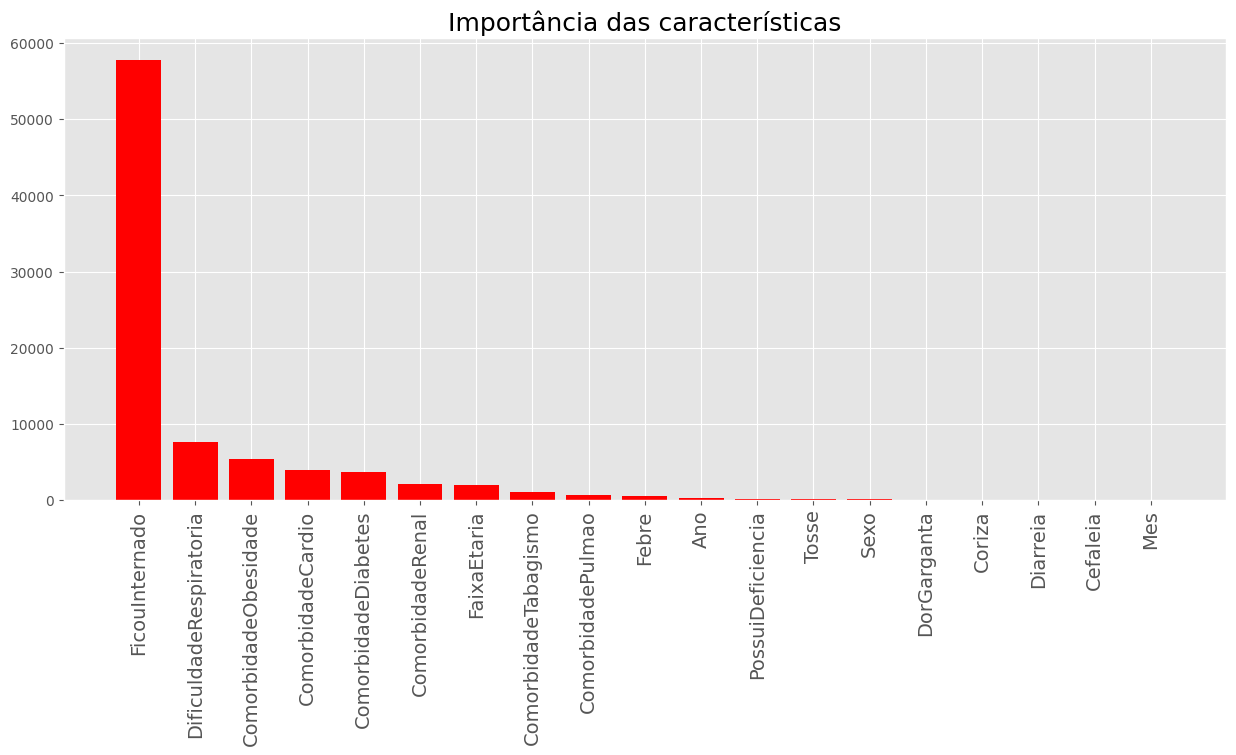

In [177]:
k_melhores = SelectKBest(score_func=chi2,k=X_train.shape[1])
kbest = k_melhores.fit_transform(X_train, y_train)
indices = np.argsort(k_melhores.scores_)[::-1]

features = []
for i in range(X_train.shape[1]):
    features.append(X_train.columns[indices[i]])
plt.figure(figsize=(15,6))
plt.bar(x=features, height=k_melhores.scores_[indices[range(X_train.shape[1])]], color='r', align='center')
plt.title('Importância das características',fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.show()


remover as variáveis com menor importância para a variável Evolução de acordo com o teste matemático do chi2

In [183]:
X_train.drop(columns=['Mes','Cefaleia','Diarreia','Coriza','DorGarganta'], inplace=True)
X_test.drop(columns=['Mes','Cefaleia','Diarreia','Coriza','DorGarganta'], inplace=True)

# Aprendizado de maquina

In [247]:
def AM(nome, modelo, X_treino, y_treino, X_teste, y_teste):
  np.random.seed(100)
  modelos = []
  model  = modelo
  model.fit(X_treino, y_treino)
  y_pred = model.predict(X_teste)

  acuracia = accuracy_score(y_teste, y_pred,)
  roc_auc = roc_auc_score(y_teste, y_pred)
  recall = recall_score(y_teste, y_pred, average='macro')
  precision = precision_score(y_teste, y_pred, average='macro')
  f1 = f1_score(y_teste, y_pred, average='macro')
  print(f'Modelo utilizado: {modelo}')
  print(f'Acuracia: {round(acuracia*100,2)}%')
  print(f'ROC_AUC: {round(roc_auc*100,2)}%')
  print(f'Recall {round(recall*100,2)}%')
  print(f'Precision {round(precision*100,2)}%')
  print(f'F1-score: {round(f1*100,2)}%')
  print(classification_report(y_teste, y_pred))

  cm = confusion_matrix(y_teste, y_pred, labels=model.classes_)

  sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
              xticklabels=['Sobreviveu','Óbito'], yticklabels=['Sobreviveu','Óbito'])
  
  y_pred_proba = modelo.predict_proba(X_teste)[::,1]
  fpr, tpr, _ = roc_curve(y_teste, y_pred_proba)
  auc = roc_auc_score(y_teste, y_pred_proba)

  plt.figure(figsize=(7,5))
  plt.plot(fpr,tpr)
  plt.title(f'Curva ROC {nome}', fontsize=18)
  plt.xlabel('Taxa falsos positivos', fontsize=16)
  plt.ylabel('Taxa verdadeiros positivos', fontsize=16)
  plt.plot([0,1],[0,1], color='blue', lw=2, linestyle='--')
  plt.show()

  return [f'{nome}', modelo, round(acuracia*100,4), round(roc_auc*100,4), recall*100, precision*100, f1*100]

# Balanceamento dos dados de treino

## Undersampling

In [185]:
np.random.seed(100)

rus = RandomUnderSampler(replacement=True)

X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [186]:
X_rus.shape

(2314, 14)

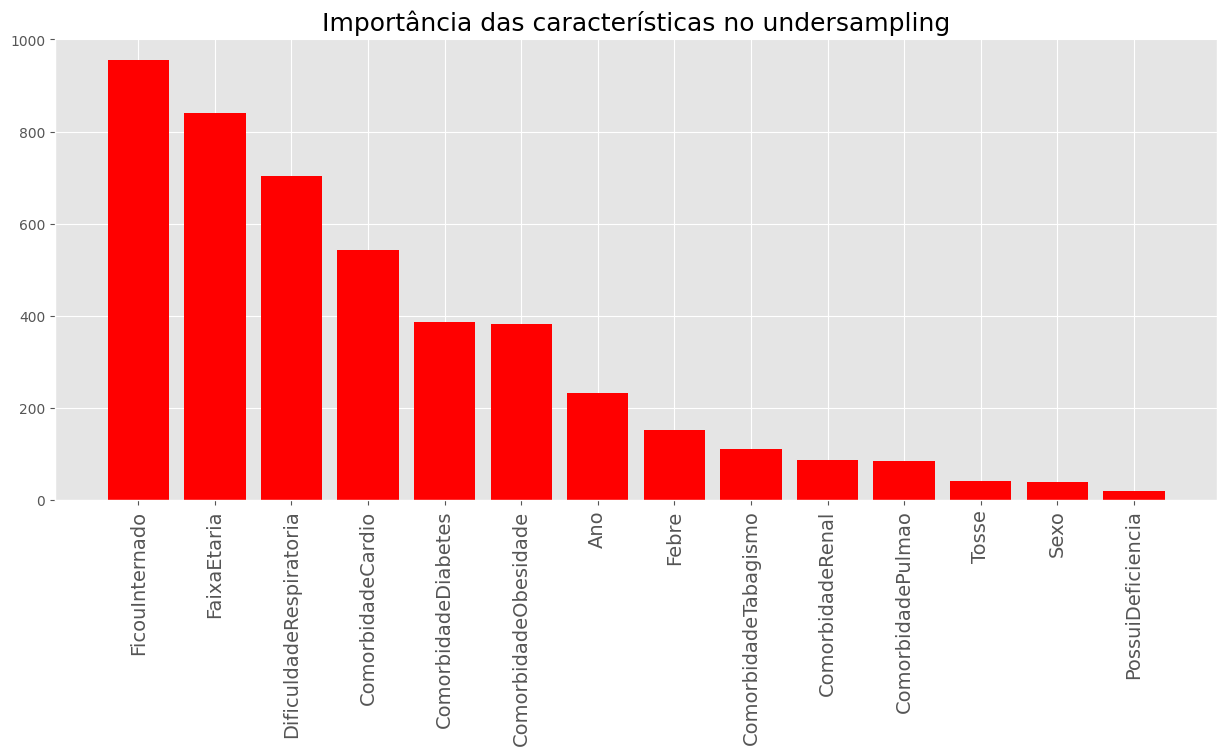

In [187]:
k_melhores = SelectKBest(score_func=chi2,k=X_rus.shape[1])
kbest = k_melhores.fit_transform(X_rus, y_rus)
indices = np.argsort(k_melhores.scores_)[::-1]


features = []
for i in range(X_rus.shape[1]):
    features.append(X_train.columns[indices[i]])
plt.figure(figsize=(15,6))
plt.bar(features, k_melhores.scores_[indices[range(X_rus.shape[1])]], color='r', align='center')
plt.title('Importância das características no undersampling',fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.show()

In [217]:
X_rus_principais = X_rus[['FicouInternado','FaixaEtaria','DificuldadeRespiratoria','ComorbidadeCardio','ComorbidadeDiabetes','ComorbidadeObesidade','Ano']]
X_rus_principais

FicouInternado  FaixaEtaria  DificuldadeRespiratoria  ComorbidadeCardio  \
0                  0            6                        0                  0   
1                  0            5                        0                  0   
2                  0            6                        0                  0   
3                  0            7                        0                  0   
4                  0            5                        0                  0   
...              ...          ...                      ...                ...   
2309               1            9                        0                  0   
2310               1           10                        1                  1   
2311               1            8                        1                  1   
2312               0           10                        1                  0   
2313               1            6                        1                  0   

      ComorbidadeDiabetes  ComorbidadeObesidade  Ano  
0                       0                     0    2  
1                       0                     0    2  
2                       0                     0    0  
3                       0                     0    2  
4                       0                     0    2  
...                   ...                   ...  ...  
2309                    0                     0    0  
2310                    0                     0    1  
2311                    1                     0    1  
2312                    0                     0    1  
2313                    0                     1    0  

[2314 rows x 7 columns]

## Smote

In [188]:
np.random.seed(100)

smote = SMOTE()

X_smt, y_smt = smote.fit_resample(X_train,y_train)#para obtenção dos hiperparametros

In [189]:
X_smt.shape

(228936, 14)

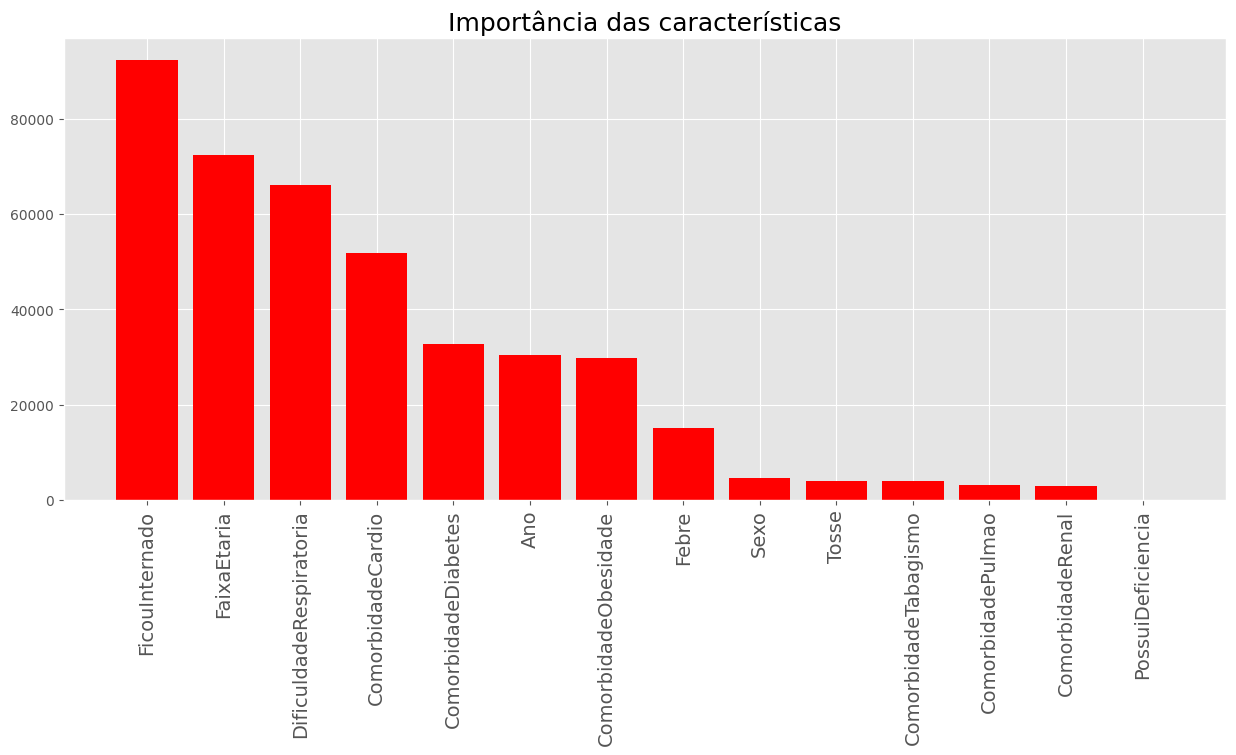

In [191]:
k_melhores = SelectKBest(score_func=chi2,k=X_smt.shape[1])
kbest = k_melhores.fit_transform(X_smt, y_smt)
indices = np.argsort(k_melhores.scores_)[::-1]


features = []
for i in range(X_smt.shape[1]):
    features.append(X_train.columns[indices[i]])
plt.figure(figsize=(15,6))
plt.bar(features, k_melhores.scores_[indices[range(X_smt.shape[1])]], color='r', align='center')
plt.title('Importância das características',fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.show()

# Árvore de decisão

## Árvore de decisão Undersampling

Utilizarei o cross validation estratificado em conjunto com o GridSearchCV para encontrar os melhores parâmetros do modelo que apresentem maior valor para a métrica ROC AUC

In [220]:
np.random.seed(100)

param_grid = {
    'max_depth': np.arange(1,20,2),
    'min_samples_leaf': np.arange(1,20,2),
    'min_samples_split': np.arange(2,20,2),
    'max_features': np.arange(1,15,2)
    }
print(param_grid)
model  = DecisionTreeClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus, y_rus)
train_pred = grid_search.predict(X_rus)
gs_pred = grid_search.predict(X_test)

print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]), 'max_features': array([ 1,  3,  5,  7,  9, 11, 13])}
Fitting 5 folds for each of 6300 candidates, totalling 31500 fits

DecisionTreeClassifier(max_depth=11, max_features=7, min_samples_leaf=19,
                       random_state=100)
ROC AUC treino: 95.28999999999999%
ROC AUC test: 95.66%


Modelo utilizado: DecisionTreeClassifier(max_depth=11, max_features=7, min_samples_leaf=19,
                       random_state=100)
Acuracia: 98.51%
ROC_AUC: 95.66%
Recall 95.66%
Precision 69.46%
F1-score: 77.07%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29376
           1       0.39      0.93      0.55       290

    accuracy                           0.99     29666
   macro avg       0.69      0.96      0.77     29666
weighted avg       0.99      0.99      0.99     29666



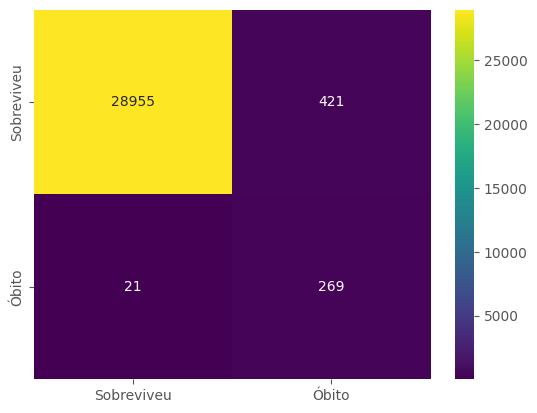

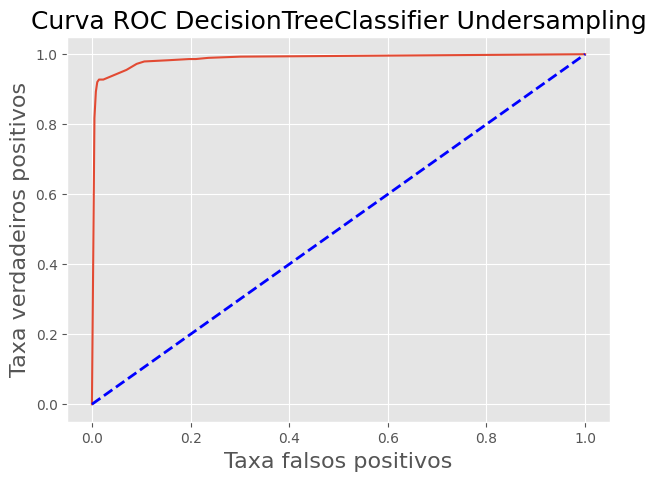

In [248]:
rus_tree = AM('DecisionTreeClassifier Undersampling',grid_search.best_estimator_, X_rus, y_rus, X_test, y_test)

### Testando o conjunto com apenas as variaveis de maior impacto

In [249]:
np.random.seed(100)

param_grid = {
    'max_depth': np.arange(1,10,2),
    'min_samples_leaf': np.arange(1,10,2),
    'min_samples_split': np.arange(2,10,2),
    'max_features': np.arange(1,X_rus_principais.shape[1],2)
    }
print(param_grid)
model  = DecisionTreeClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus_principais, y_rus)

train_pred = grid_search.predict(X_rus_principais)
gs_pred = grid_search.predict(X_test[X_rus_principais.columns])

print()
print(grid_search.best_estimator_)

print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')


{'max_depth': array([1, 3, 5, 7, 9]), 'min_samples_leaf': array([1, 3, 5, 7, 9]), 'min_samples_split': array([2, 4, 6, 8]), 'max_features': array([1, 3, 5])}
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

DecisionTreeClassifier(max_depth=5, max_features=3, min_samples_leaf=7,
                       random_state=100)
ROC AUC treino: 96.72%
ROC AUC test: 96.72%


Modelo utilizado: DecisionTreeClassifier(max_depth=5, max_features=3, min_samples_leaf=7,
                       random_state=100)
Acuracia: 97.91%
ROC_AUC: 96.72%
Recall 96.72%
Precision 65.63%
F1-score: 73.04%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29376
           1       0.31      0.96      0.47       290

    accuracy                           0.98     29666
   macro avg       0.66      0.97      0.73     29666
weighted avg       0.99      0.98      0.98     29666



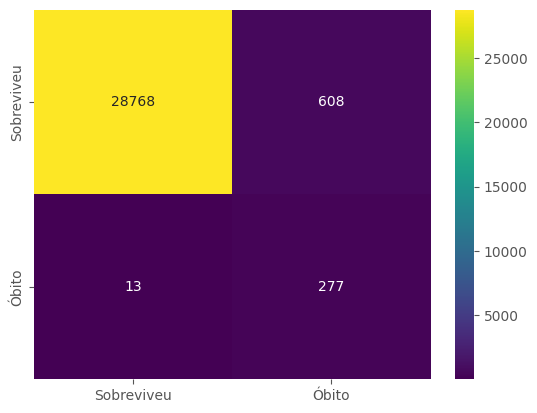

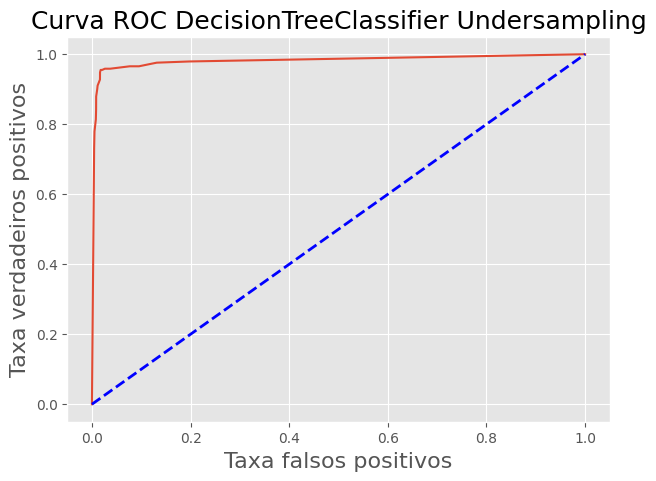

In [251]:
rus_tree_principais = AM('DecisionTreeClassifier Undersampling',grid_search.best_estimator_, X_rus_principais, y_rus, X_test[X_rus_principais.columns], y_test)

# Random Forest

## Random Forest Undersampling

Utilizarei o cross validation estratificado em conjunto com o GridSearchCV para encontrar os melhores parâmetros do modelo que apresentem maior valor para a métrica ROC AUC

In [253]:
np.random.seed(100)

param_grid = {
    'max_depth': np.arange(1,10,2),
    'min_samples_leaf': np.arange(1,10,2),
    'min_samples_split': np.arange(2,10,2),
    'n_estimators':np.arange(50,150,25),
    'max_features': np.arange(1,15,2)
    }
print(param_grid)
model  = RandomForestClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus, y_rus)
train_pred = grid_search.predict(X_train)
gs_pred = grid_search.predict(X_test)

print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_train, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'max_depth': array([1, 3, 5, 7, 9]), 'min_samples_leaf': array([1, 3, 5, 7, 9]), 'min_samples_split': array([2, 4, 6, 8]), 'n_estimators': array([ 50,  75, 100, 125]), 'max_features': array([ 1,  3,  5,  7,  9, 11, 13])}
Fitting 5 folds for each of 2800 candidates, totalling 14000 fits

RandomForestClassifier(max_depth=9, max_features=3, min_samples_leaf=7,
                       n_estimators=125, random_state=100)
ROC AUC treino: 96.83%
ROC AUC test: 96.61999999999999%


Modelo utilizado: RandomForestClassifier(max_depth=9, max_features=3, min_samples_leaf=7,
                       n_estimators=125, random_state=100)
Acuracia: 97.37%
ROC_AUC: 96.62%
Recall 96.62%
Precision 63.26%
F1-score: 70.12%
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     29376
           1       0.27      0.96      0.42       290

    accuracy                           0.97     29666
   macro avg       0.63      0.97      0.70     29666
weighted avg       0.99      0.97      0.98     29666



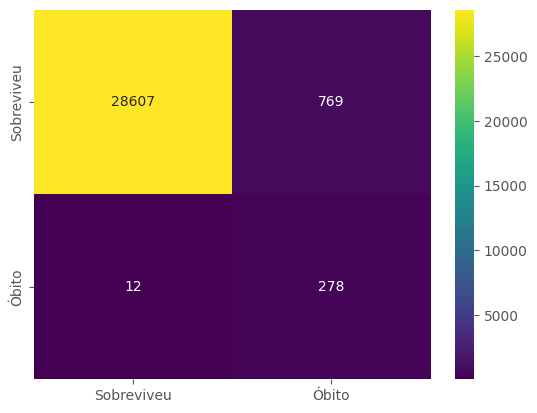

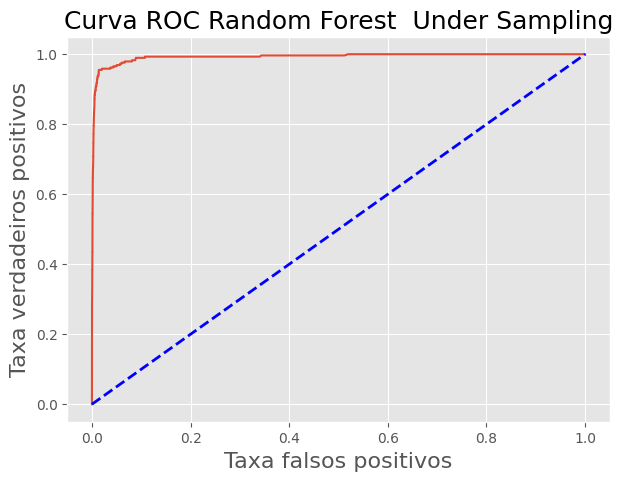

In [254]:
rus_forest = AM('Random Forest  Under Sampling',RandomForestClassifier(max_depth=9, max_features=3, min_samples_leaf=7,
                       n_estimators=125, random_state=100), X_rus, y_rus, X_test, y_test)

## Random Forest Undersampling principais caracteristicas

In [255]:
np.random.seed(100)

param_grid = {
    'max_depth': np.arange(1,10,2),
    'min_samples_leaf': np.arange(1,10,2),
    'min_samples_split': np.arange(2,10,2),
    'n_estimators':np.arange(50,150,25),
    'max_features': np.arange(1,X_rus_principais.shape[1],2)
    }
print(param_grid)
model  = RandomForestClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus_principais, y_rus)

train_pred = grid_search.predict(X_rus_principais)
gs_pred = grid_search.predict(X_test[X_rus_principais.columns])

print()
print(grid_search.best_estimator_)

print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'max_depth': array([1, 3, 5, 7, 9]), 'min_samples_leaf': array([1, 3, 5, 7, 9]), 'min_samples_split': array([2, 4, 6, 8]), 'n_estimators': array([ 50,  75, 100, 125]), 'max_features': array([1, 3, 5])}
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits

RandomForestClassifier(max_depth=7, max_features=1, min_samples_leaf=7,
                       n_estimators=125, random_state=100)
ROC AUC treino: 97.32%
ROC AUC test: 96.53%


Modelo utilizado: RandomForestClassifier(max_depth=7, max_features=1, min_samples_leaf=7,
                       n_estimators=125, random_state=100)
Acuracia: 96.84%
ROC_AUC: 96.53%
Recall 96.53%
Precision 61.56%
F1-score: 67.85%
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     29376
           1       0.23      0.96      0.37       290

    accuracy                           0.97     29666
   macro avg       0.62      0.97      0.68     29666
weighted avg       0.99      0.97      0.98     29666



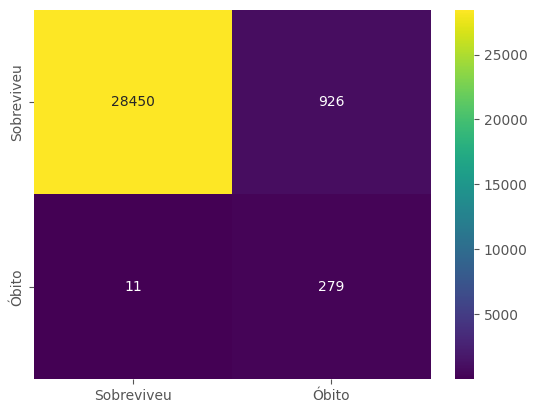

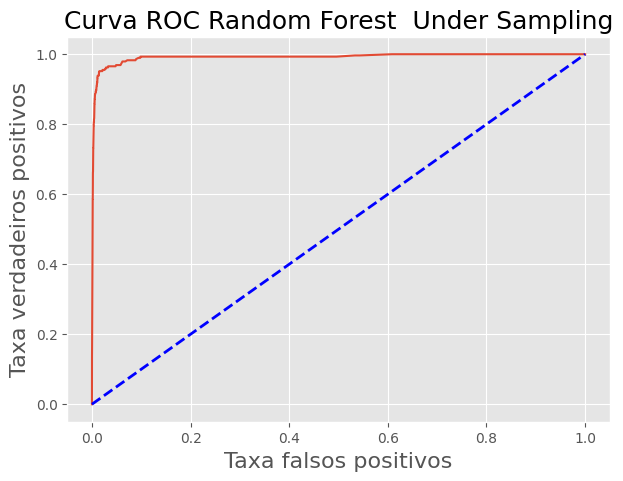

In [257]:
rus_forest_principais = AM('Random Forest  Under Sampling',RandomForestClassifier(max_depth=7, max_features=1, min_samples_leaf=7,
                       n_estimators=125, random_state=100), X_rus_principais, y_rus, X_test[X_rus_principais.columns], y_test)

## Random Forest Smote

In [352]:
np.random.seed(100)

param_grid = {
    'max_depth': np.arange(1,10,4),
    'min_samples_leaf': np.arange(1,10,4),
    'min_samples_split': np.arange(2,10,4),
    'n_estimators':np.arange(50,200,50),
    'max_features': np.arange(1,15,5)
    }
print(param_grid)
model  = RandomForestClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_smt, y_smt)
train_pred = grid_search.predict(X_train)
gs_pred = grid_search.predict(X_test)

print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_train, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'max_depth': array([1, 5, 9]), 'min_samples_leaf': array([1, 5, 9]), 'min_samples_split': array([2, 6]), 'n_estimators': array([ 50, 100, 150]), 'max_features': array([ 1,  6, 11])}
Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

# Adaboost

## Adaboost Undersampling

Utilizarei o cross validation estratificado em conjunto com o GridSearchCV para encontrar os melhores parâmetros do modelo que apresentem maior valor para a métrica ROC AUC

In [261]:
np.random.seed(100)

param_grid = {
    'learning_rate': np.arange(0.01,1, 0.01),
    'n_estimators':np.arange(50,150,20),
    }
print(param_grid)
model  = AdaBoostClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus, y_rus)
train_pred = grid_search.predict(X_train)
gs_pred = grid_search.predict(X_test)

print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_train, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]), 'n_estimators': array([ 50,  70,  90, 110, 130])}
Fitting 5 folds for each of 495 candidates, totalling 2475 fits

AdaBoostClassifier(learning_rate=0.14, n_estimators=130, random_state=100)
ROC AUC treino: 96.66%
ROC AUC test: 96.32%


Modelo utilizado: AdaBoostClassifier(learning_rate=0.14, n_estimators=130, random_state=100)
Acuracia: 97.79%
ROC_AUC: 96.32%
Recall 96.32%
Precision 64.97%
F1-score: 72.22%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29376
           1       0.30      0.95      0.46       290

    accuracy                           0.98     29666
   macro avg       0.65      0.96      0.72     29666
weighted avg       0.99      0.98      0.98     29666



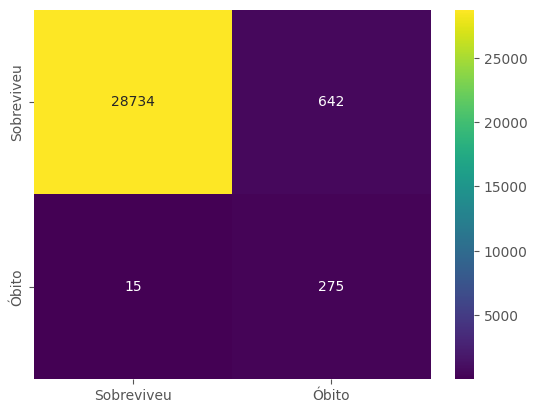

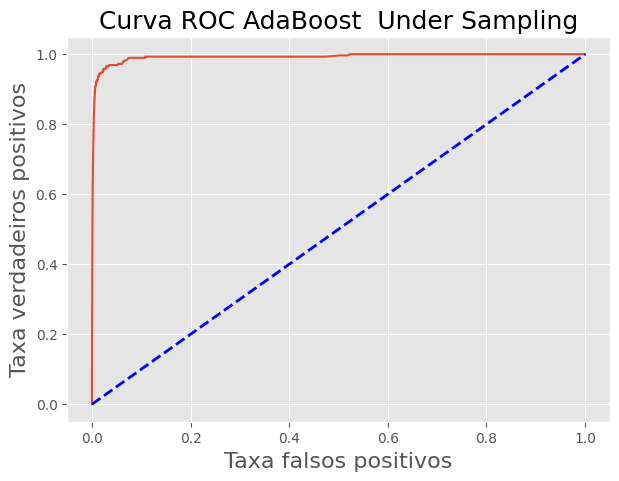

In [262]:
rus_ada = AM('AdaBoost  Under Sampling',AdaBoostClassifier(learning_rate=0.14, n_estimators=130, random_state=100), X_rus, y_rus, X_test, y_test)

### Ada boost undersampling com as principais características

In [264]:
np.random.seed(100)

param_grid = {
    'learning_rate': np.arange(0.01,1, 0.01),
    'n_estimators':np.arange(50,150,20),
    }
print(param_grid)
model  = AdaBoostClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus_principais, y_rus)
train_pred = grid_search.predict(X_rus_principais)
gs_pred = grid_search.predict(X_test[X_rus_principais.columns])

print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]), 'n_estimators': array([ 50,  70,  90, 110, 130])}
Fitting 5 folds for each of 495 candidates, totalling 2475 fits

AdaBoostClassifier(learning_rate=0.24000000000000002, random_state=100)
ROC AUC treino: 96.37%
ROC AUC test: 96.15%


Modelo utilizado: AdaBoostClassifier(learning_rate=0.14, n_estimators=130, random_state=100)
Acuracia: 97.52%
ROC_AUC: 96.18%
Recall 96.18%
Precision 63.77%
F1-score: 70.73%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29376
           1       0.28      0.95      0.43       290

    accuracy                           0.98     29666
   macro avg       0.64      0.96      0.71     29666
weighted avg       0.99      0.98      0.98     29666



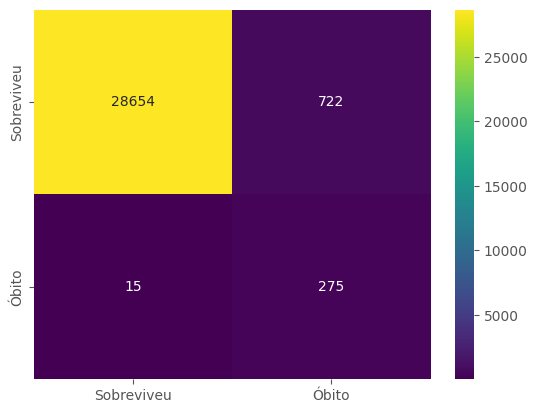

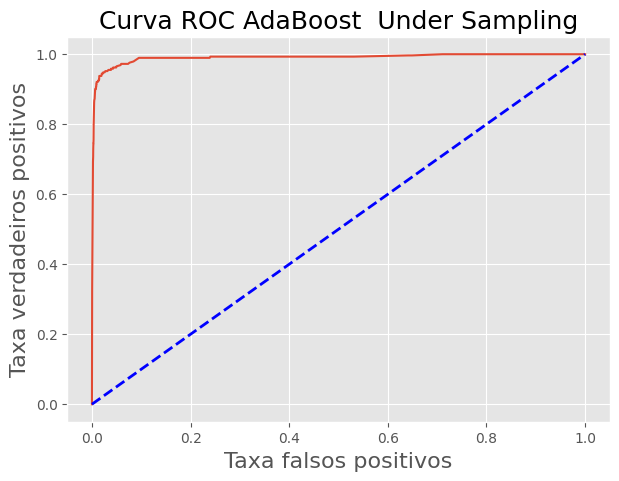

In [265]:
rus_ada_principais = AM('AdaBoost  Under Sampling',AdaBoostClassifier(learning_rate=0.14, n_estimators=130, random_state=100), X_rus_principais, y_rus, X_test[X_rus_principais.columns], y_test)

# XGBoost

## XGBoost Undersampling

Utilizarei o cross validation estratificado em conjunto com o GridSearchCV para encontrar os melhores parâmetros do modelo que apresentem maior valor para a métrica ROC AUC

In [357]:
np.random.seed(100)

param_grid = {
    'learning_rate': np.arange(0.01,1, 0.01),
    'max_depth': np.arange(1,11,2),
    'n_estimators':np.arange(50,150,20),
    }
print(param_grid)
model  = xgb.XGBClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus, y_rus)
train_pred = grid_search.predict(X_rus)
gs_pred = grid_search.predict(X_test)
 
print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]), 'max_depth': array([1, 3, 5, 7, 9]), 'n_estimators': array([ 50,  70,  90, 110, 130])}
Fitting 5 folds for each of 2475 candidates, totalling 12375 fits
[20:50:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with t

c:\Users\R2\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\R2\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Modelo utilizado: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.8200000000000001,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Acuracia: 97.24%
ROC_AUC: 

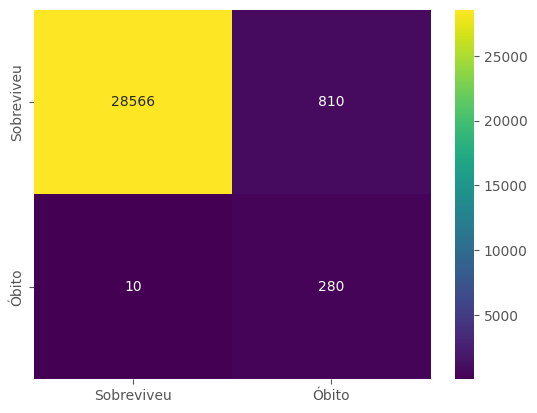

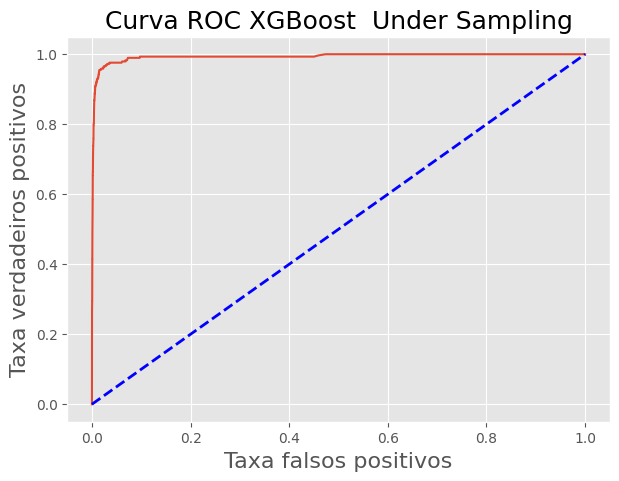

In [266]:
rus_xgb = AM('XGBoost  Under Sampling',xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.8200000000000001,
              max_delta_step=0, max_depth=1, min_child_weight=1,
              monotone_constraints='()', n_estimators=50, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), X_rus, y_rus, X_test, y_test)

### XGBoost com principais caracteristicas

In [269]:
np.random.seed(100)

param_grid = {
    'learning_rate': np.arange(0.01,1, 0.01),
    'max_depth': np.arange(1,11,2),
    'n_estimators':np.arange(50,150,20)
    }

print(param_grid)
model  = xgb.XGBClassifier(random_state=100)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, verbose=3, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_rus_principais, y_rus)
train_pred = grid_search.predict(X_rus_principais)
gs_pred = grid_search.predict(X_test[X_rus_principais.columns])
 
print()
print(grid_search.best_estimator_)
print(f'ROC AUC treino: {round(roc_auc_score(y_rus, train_pred),4)*100}%')
print(f'ROC AUC test: {round(roc_auc_score(y_test, gs_pred),4)*100}%')

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]), 'max_depth': array([1, 3, 5, 7, 9]), 'n_estimators': array([ 50,  70,  90, 110, 130])}
Fitting 5 folds for each of 2475 candidates, totalling 12375 fits
[12:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with t

[12:23:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Modelo utilizado: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.13, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Acuracia: 97.09%
ROC_AUC: 96.48%
Recall 

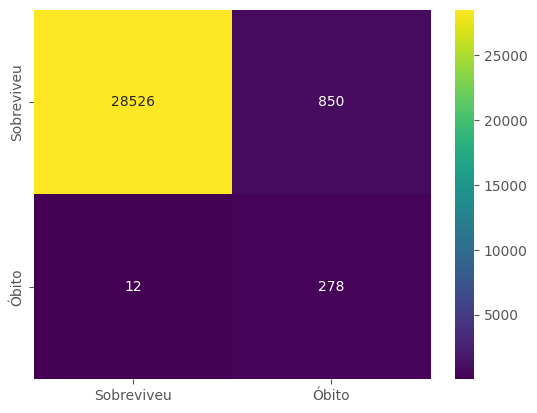

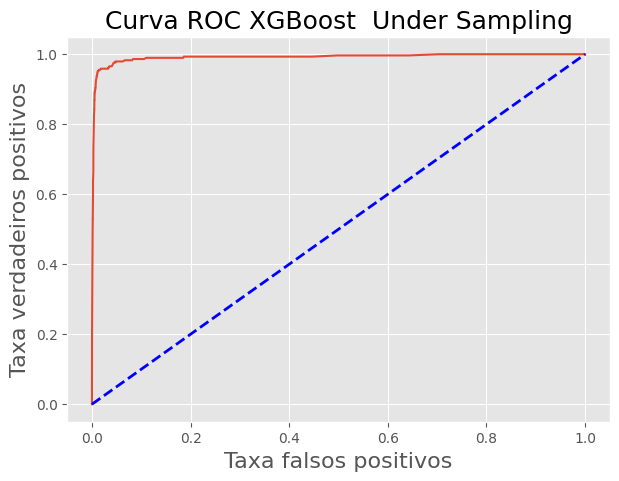

In [271]:
rus_xgb_principais = AM('XGBoost  Under Sampling',xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.13, max_delta_step=0,
              max_depth=3, min_child_weight=1,
              monotone_constraints='()', n_estimators=50, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), X_rus_principais, y_rus, X_test[X_rus_principais.columns], y_test)

# Comparando modelos

In [369]:
pd.DataFrame([rus_tree, rus_forest, rus_ada, rus_xgb,
              rus_tree_principais, rus_ada_principais], columns=['nome', 'modelo', 'acuracia', 'roc_auc', 'recall', 'precision', 'f1']).sort_values('roc_auc', ascending=False)

nome  \
0  DecisionTreeClassifier Undersampling   
3               XGBoost  Under Sampling   
1         Random Forest  Under Sampling   
2              AdaBoost  Under Sampling   

                                              modelo  acuracia  roc_auc  \
0  DecisionTreeClassifier(max_depth=5, max_featur...   96.2381  96.9055   
3  XGBClassifier(base_score=0.5, booster='gbtree'...   97.2359  96.8972   
1  (DecisionTreeClassifier(max_depth=9, max_featu...   97.3674  96.6221   
2  (DecisionTreeClassifier(max_depth=1, random_st...   97.7853  96.3211   

      recall  precision         f1  
0  96.905508  60.152851  65.857298  
3  96.897186  62.826539  69.582373  
1  96.622143  63.255062  70.119486  
2  96.321064  64.968460  72.218600